In [2]:
from Bio import SeqIO
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [4]:
seqdict = {}
for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa', 'fasta'):
    seqdict[record.id] = str(record.seq)

In [5]:
seqlens = [(key, len(val)) for key, val in seqdict.items()]
length_df = pd.DataFrame(seqlens, columns=['name', 'length'])
print(length_df.head())

                         name  length
0  Anabarilius_grahami_g18.t1     282
1  Anabarilius_grahami_g20.t1     282
2  Anabarilius_grahami_g22.t1     281
3  Anabarilius_grahami_g23.t1     288
4  Anabarilius_grahami_g25.t1     282


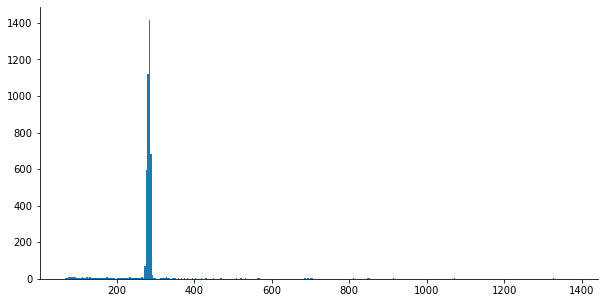

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_yscale('log')
plt.hist(length_df.length, bins=len(set(length_df.length)))
sns.despine()
plt.show()